The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
%pip install d2l==0.17.5
%pip install -U mxnet-cu101==1.7.0

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement mxnet-cu101==1.7.0 (from versions: 1.5.0)
ERROR: No matching distribution found for mxnet-cu101==1.7.0


# AutoRec: Rating Prediction with Autoencoders

Although the matrix factorization model achieves decent performance on the rating prediction task, it is essentially a linear model. Thus, such models are not capable of capturing complex nonlinear and intricate relationships that may be predictive of users' preferences. In this section, we introduce a nonlinear neural network collaborative filtering model, AutoRec :cite:`Sedhain.Menon.Sanner.ea.2015`. It identifies collaborative filtering (CF) with an autoencoder architecture and aims to integrate nonlinear transformations into CF on the basis of explicit feedback. Neural networks have been proven to be capable of approximating any continuous function, making it suitable to address the limitation of matrix factorization and enrich the expressiveness of matrix factorization.

On one hand, AutoRec has the same structure as an autoencoder which consists of an input layer, a hidden layer, and a reconstruction (output) layer.  An autoencoder is a neural network that learns to copy its input to its output in order to code the inputs into the hidden (and usually low-dimensional) representations. In AutoRec, instead of explicitly embedding users/items into low-dimensional space, it uses the column/row of the interaction matrix as the input, then reconstructs the interaction matrix in the output layer.

On the other hand, AutoRec differs from a traditional autoencoder: rather than learning the hidden representations, AutoRec focuses on learning/reconstructing the output layer. It uses a partially observed interaction matrix as the input, aiming to reconstruct a completed rating matrix. In the meantime, the missing entries of the input are filled in the output layer via reconstruction for the purpose of recommendation. 

There are two variants of AutoRec: user-based and item-based. For brevity, here we only introduce the item-based AutoRec. User-based AutoRec can be derived accordingly.


## Model

Let $\mathbf{R}_{*i}$ denote the $i^\mathrm{th}$ column of the rating matrix, where unknown ratings are set to zeros by default. The neural architecture is defined as:

$$
h(\mathbf{R}_{*i}) = f(\mathbf{W} \cdot g(\mathbf{V} \mathbf{R}_{*i} + \mu) + b)
$$

where $f(\cdot)$ and $g(\cdot)$ represent activation functions, $\mathbf{W}$ and $\mathbf{V}$ are weight matrices, $\mu$ and $b$ are biases. Let $h( \cdot )$ denote the whole network of AutoRec. The output $h(\mathbf{R}_{*i})$ is the reconstruction of the $i^\mathrm{th}$ column of the rating matrix.

The following objective function aims to minimize the reconstruction error:

$$
\underset{\mathbf{W},\mathbf{V},\mu, b}{\mathrm{argmin}} \sum_{i=1}^M{\parallel \mathbf{R}_{*i} - h(\mathbf{R}_{*i})\parallel_{\mathcal{O}}^2} +\lambda(\| \mathbf{W} \|_F^2 + \| \mathbf{V}\|_F^2)
$$

where $\| \cdot \|_{\mathcal{O}}$ means only the contribution of observed ratings are considered, that is, only weights that are associated with observed inputs are updated during back-propagation.


In [ ]:
import mxnet as mx
from mxnet import autograd, gluon, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

## Implementing the Model

A typical autoencoder consists of an encoder and a decoder. The encoder projects the input to hidden representations and the decoder maps the hidden layer to the reconstruction layer. We follow this practice and create the encoder and decoder with dense layers. The activation of encoder is set to `sigmoid` by default and no activation is applied for decoder. Dropout is included after the encoding transformation to reduce over-fitting. The gradients of unobserved inputs are masked out to ensure that only observed ratings contribute to the model learning process.


In [ ]:
class AutoRec(nn.Block):
    def __init__(self, num_hidden, num_users, dropout=0.05):
        super(AutoRec, self).__init__()
        self.encoder = nn.Dense(num_hidden, activation='sigmoid',
                                use_bias=True)
        self.decoder = nn.Dense(num_users, use_bias=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input):
        hidden = self.dropout(self.encoder(input))
        pred = self.decoder(hidden)
        if autograd.is_training():  # Mask the gradient during training
            return pred * np.sign(input)
        else:
            return pred

## Reimplementing the Evaluator

Since the input and output have been changed, we need to reimplement the evaluation function, while we still use RMSE as the accuracy measure.


In [ ]:
def evaluator(network, inter_matrix, test_data, devices):
    scores = []
    for values in inter_matrix:
        feat = gluon.utils.split_and_load(values, devices, even_split=False)
        scores.extend([network(i).asnumpy() for i in feat])
    recons = np.array([item for sublist in scores for item in sublist])
    # Calculate the test RMSE
    rmse = np.sqrt(np.sum(np.square(test_data - np.sign(test_data) * recons))
                   / np.sum(np.sign(test_data)))
    return float(rmse)

## Training and Evaluating the Model

Now, let us train and evaluate AutoRec on the MovieLens dataset. We can clearly see that the test RMSE is lower than the matrix factorization model, confirming the effectiveness of neural networks in the rating prediction task.


train loss 0.000, test RMSE 0.902
34607946.7 examples/sec on [gpu(0), gpu(1)]


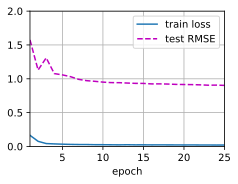

In [ ]:
devices = d2l.try_all_gpus()
# Load the MovieLens 100K dataset
df, num_users, num_items = d2l.read_data_ml100k()
train_data, test_data = d2l.split_data_ml100k(df, num_users, num_items)
_, _, _, train_inter_mat = d2l.load_data_ml100k(train_data, num_users,
                                                num_items)
_, _, _, test_inter_mat = d2l.load_data_ml100k(test_data, num_users,
                                               num_items)
train_iter = gluon.data.DataLoader(train_inter_mat, shuffle=True,
                                   last_batch="rollover", batch_size=256,
                                   num_workers=d2l.get_dataloader_workers())
test_iter = gluon.data.DataLoader(np.array(train_inter_mat), shuffle=False,
                                  last_batch="keep", batch_size=1024,
                                  num_workers=d2l.get_dataloader_workers())
# Model initialization, training, and evaluation
net = AutoRec(500, num_users)
net.initialize(ctx=devices, force_reinit=True, init=mx.init.Normal(0.01))
lr, num_epochs, wd, optimizer = 0.002, 25, 1e-5, 'adam'
loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {"learning_rate": lr, 'wd': wd})
d2l.train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
                        devices, evaluator, inter_mat=test_inter_mat)

## Summary

* We can frame the matrix factorization algorithm with autoencoders, while integrating non-linear layers and dropout regularization. 
* Experiments on the MovieLens 100K dataset show that AutoRec achieves superior performance than matrix factorization.



## Exercises

* Vary the hidden dimension of AutoRec to see its impact on the model performance.
* Try to add more hidden layers. Is it helpful to improve the model performance?
* Can you find a better combination of decoder and encoder activation functions?


[Discussions](https://discuss.d2l.ai/t/401)
